# P5 : Segmentation des clients d'un site e-commerce 

<p><strong>Contexte :</strong> Le client <strong>Olist</strong>, une solution de vente sur les marketplaces en ligne,souhaite obtenir une <strong>Segmentation de ses clients</strong>.</p>
    
<p><strong>Objectif :</strong> Comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.</p>
    
<p><strong>Mission :</strong> Fournir à l’équipe marketing :
<ul>
    <li>une <strong>description actionable</strong> de la segmentation et de sa logique sous-jacente pour une utilisation optimale,</li>
    <li>une <strong>proposition de contrat de maintenance</strong> basée sur une analyse de la stabilité des segments au cours du temps.</li>
</ul>
</p>

<hr/>

# *Partie 2 : Segmentation des données*

## I. Importation des Librairies utiles
<p>Plusieurs librairies sont utiles tout au long de l'étude. Elles sont importées dans cette section.</p>

In [1]:
# librairies pour ne pas afficher les warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# librairies pour les graphes
%pylab  inline
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from sklearn.manifold import TSNE

Populating the interactive namespace from numpy and matplotlib


In [3]:
# librairies pour les analyses
import pandas as pd
import math
import datetime
from dateutil.relativedelta import relativedelta

In [4]:
# librairies pour les modèles
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

<hr/>

## II. Importation des Données
<p>Dans cette section, on verra des essais de segmentations des données.</p>

In [5]:
# importation du jeu de données à partir de .csv
X_features = pd.read_csv('../Dataset/x_features.csv',index_col='customer_unique_id')

In [6]:
X_features.head(3)

,recence,frequence,montant,n_payment,pay_credit_card,pay_debit_card,pay_boleto,pay_voucher,seller_distance,freight_value,estimated_delivery_days,product_description_lenght,product_category_lenght,product_photos_qty,day_off,review_score,review_comment_lenght
customer_unique_id,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,129.9,8.0,1,0,0,0,4504.736604,12.00,10,236.0,14.0,1.0,0.0,5.0,111.0
0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,18.9,1.0,1,0,0,0,485.450140,8.29,7,635.0,13.0,1.0,0.0,4.0,3.0
0000f46a3911fa3c0805444483337064,585,1,69.0,8.0,1,0,0,0,14954.133656,17.22,27,177.0,10.0,3.0,0.0,3.0,3.0


<hr/>

## III. Clustering global

In [7]:
X_values = X_features.values
X_names = X_features.columns

In [8]:
etiquettes = ['recence','fréquence','montant','payement par carte de crédit','payement de carte de débit',
              'payement par billet','payement par voucher','distance du vendeur','frais de livraison',
              'temps estimé de livraison','taille de description de produits','taille de description de catégorie de produits',
              'nombre de photos','nombre de jours sans achat','notes du client','taille des commentaires du client'
             ]

### A) Essais de modèles

#### 1. DBSCAN

* **Estimation des paramètres**

In [9]:
minpts = 34 # ~2 fois la taille du jeu

In [10]:
neighbors = NearestNeighbors(n_neighbors=34) # ~2 fois la taille du jeu
neighbors_fit = neighbors.fit(X_values)
distances, indices = neighbors_fit.kneighbors(X_values)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

(50.0, 300.0)

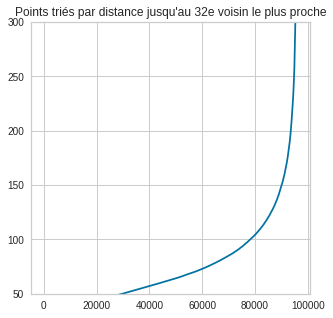

In [11]:
fig=plt.figure(figsize=(5,5))
plt.plot(distances)
plt.title("Points triés par distance jusqu'au 34e voisin le plus proche")
plt.ylim(50,300)

***Observation :*** Selon ce graphe, le paramètre eps serait ~125.

* **Implémentation des paramètres au modèle**

In [12]:
db = DBSCAN(eps=125,min_samples=minpts).fit(X_values)

* **Evaluation du modèle**

In [13]:
# nombre de clusters
db_labels = db.labels_
n_cluster = len(set(db_labels))

# silhouette coefficient
db_score_sil = metrics.silhouette_score(X_values,db_labels)

# davies bouldin score
db_score_db = metrics.davies_bouldin_score(X_values,db_labels)

In [14]:
print("Nombre de cluster: %i"% n_cluster)
print("Silhouette Coefficient: %0.3f"% db_score_sil)
print("Score Davies Bouldin: %0.3f"% db_score_db)

Nombre de cluster: 14
Silhouette Coefficient: -0.752
Score Davies Bouldin: 2.426


In [15]:
set(db_labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

***Observation :*** D'après ces scores (silhouette proche de -1 et davies bouldin proche de 2), DBSCAN n'est pas le meilleur modèle pour cette segmentation.

#### 2. K-MEANS

* **Estimation du nombre de cluster**

<p>- Selon l'évolution des scores (Silhouette et Davies Bouldin)</p>

In [16]:
def estimation_number_cluster(data):
    inertie = []
    sil_score = []
    db_score = []

    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        inertie.append(kmeans.inertia_)
        try:
            sil_score.append(metrics.silhouette_score(data,kmeans.labels_))
            db_score.append(metrics.davies_bouldin_score(data, kmeans.labels_))
        except:
            sil_score.append(np.nan)
            db_score.append(np.nan)
    return inertie, sil_score, db_score

In [17]:
def estimation_visualizer(data,ax=None):
    inertie, sil_score, db_score = estimation_number_cluster(data)
    
    fig, ax1 = plt.subplots(figsize=(8,5))

    color = 'tab:red'
    ax1.set_xlabel('N clusters')
    ax1.set_ylabel('Inertie', color=color)
    ax1.plot(range(1, 11),inertie,'o-',color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Score', color='tab:blue')
    ax2.plot(range(1, 11),sil_score,'o-',color='tab:blue',label='Silhouette')
    ax2.plot(range(1, 11),db_score,'o-',color='tab:cyan',label='Davies Bouldin')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    plt.legend(loc='best')

    fig.tight_layout()

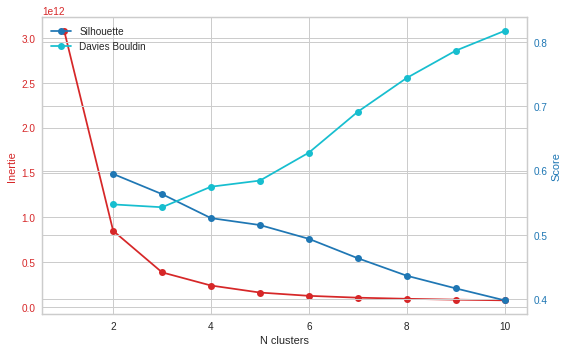

In [18]:
estimation_visualizer(X_values)

<p>- Selon la méthode Elbow</p>

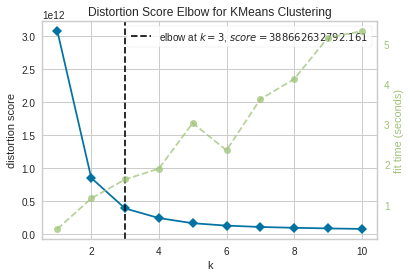

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
kmeans = KMeans()
visu_silhouette = KElbowVisualizer(kmeans, k=(1,11))
visu_silhouette.fit(X_values)
visu_silhouette.show()

***Observation :*** Selon ces 2 méthodes, on choisira le nombre de cluster 3 pour initialiser nos modèles.

* **Implémentation du clustering Kmeans avec nombre de clusters à 3**

In [20]:
# initialisation du modèle avec un nombre de cluster à 3
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters).fit(X_values)

In [21]:
kmeans_labels = kmeans.labels_
kmeans_pred = kmeans.predict(X_values)

In [22]:
adjusted_rand_score(kmeans_labels,kmeans_pred)

1.0

In [23]:
# evaluation du modèle
kmeans_score_sil = metrics.silhouette_score(X_values,kmeans_labels)
print("Silhouette Coefficient: %0.3f"% kmeans_score_sil)

Silhouette Coefficient: 0.564


In [24]:
# evaluation du modèle Davies Bouldin
kmeans_score_db = metrics.davies_bouldin_score(X_values,kmeans_labels)
print("Score Davies Bouldin: %0.3f"% kmeans_score_db)

Score Davies Bouldin: 0.543


***Observation :*** D'après ces scores, K-MEANS est un bon modèle pour cette segmentation.
<p> On retiendra donc le modèle K-MEANS avec n_cluster = 3 pour la suite de l'étude.

### B) Etudes des clusters

#### 1. Visualisation des groupes

* **Score et taille**

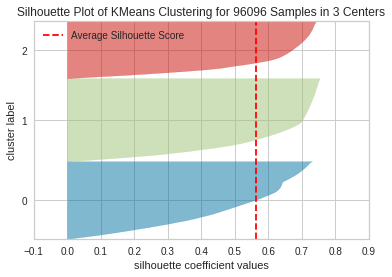

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96096 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [25]:
# Instantiate the clustering model and visualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
# Fit the data to the visualizer
visualizer.fit(X_values)        
# Finalize and render the figure
visualizer.show()        

***Observation :*** On remarque sur ce graphe que le nombre de cluster choisi est correct : 
<p>- tous les clusters ont un silhouette score supérieur au silhouette moyen qui est de 0.56, indiquant que chaque groupe est bien éloigné des autres.</p>
<p>- les épaisseurs du tracé des silhouette des clusters sont similaires, indiquant que la taille des cluster est assez similaires entre eux.</p>

* **Distance**

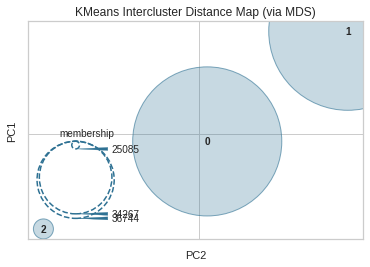

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [26]:
# Instantiate the clustering model and visualizer
visualizer = InterclusterDistance(kmeans)
# Fit the data to the visualizer
visualizer.fit(X_values)   
# Finalize and render the figure
visualizer.show()        

***Observation :*** ...

* **Représentation**

In [27]:
tsne = TSNE(n_components=2)
z = tsne.fit_transform(X_values)

<AxesSubplot:>

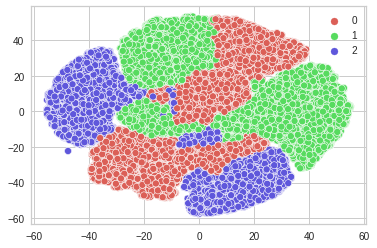

In [28]:
sns.scatterplot(x=z[:,0], y=z[:,1], hue=kmeans_labels, palette=sns.color_palette("hls", 3))

***Observation :*** ...

#### 2. Comportement des groupes

* **Données et Fonctions utiles**

In [29]:
X_features['gp'] = kmeans_labels

In [30]:
k_mean = X_features.groupby(['gp']).mean()
k_std = X_features.groupby(['gp']).std()

In [31]:
k_ranges = [(275,295), (1.21, 1.27),(137, 157),(2.6,3.1),(0.85,0.95),
            (0.01,0.03), (0.2,0.3),(0.06, 0.08),(2500,17500),
            (17,23), (20,26),(757,807),(12,13),
            (2.1,2.3), (0.6, 1.8),(4,4.2),(30,32.5)] 

In [32]:
color=['blue','green','red']
label=sorted(set(kmeans_labels))

In [148]:
def diagram(data,col,color,figsize=(6,4),degrees=0):
    n_gp = len(data.index)
    l_bar = floor(1*10/n_gp)/10
    x = range(len(col))
    fig = plt.figure(figsize=figsize)
    for i in range(n_gp):
        plt.bar(x,data.loc[i,col],width=l_bar,facecolor=color[i],alpha=0.3,edgecolor='None')
        plt.bar(x,data.loc[i,col],width=l_bar,facecolor='None',edgecolor=color[i],linewidth=1.5,label='gp %i'%i)
        x = [j + l_bar for j in x]
    plt.xticks([r + l_bar for r in range(len(col))],col,rotation=degrees)
    plt.legend(loc='best')

In [34]:
def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

In [149]:
def radar_chart(data,ranges,color,col_inf=0,col_sup=len(X_names),title='',figsize=(6,4),legend=False):
    categories_ = X_names[col_inf:col_sup]
    ranges_ = ranges[col_inf:col_sup] 
    
    fig = plt.figure(figsize=figsize)
    radar = ComplexRadar(fig, categories_,ranges_)
    
    for group in data.index:
        values = data.loc[group].values.flatten().tolist()
        values = values[col_inf:col_sup]
        values += values[:1]

        # Plot data
        radar.plot(values,color=color[group],linewidth=3,linestyle='solid',label='gp %i'%group)
        radar.fill(values,color=color[group],alpha=0.3)
    radar.ax.set_xticklabels(categories_,fontsize=15)
    radar.ax.set_title(title,fontsize=25)
    if legend:
        radar.ax.legend(loc='upper right')

* **Interpretation**

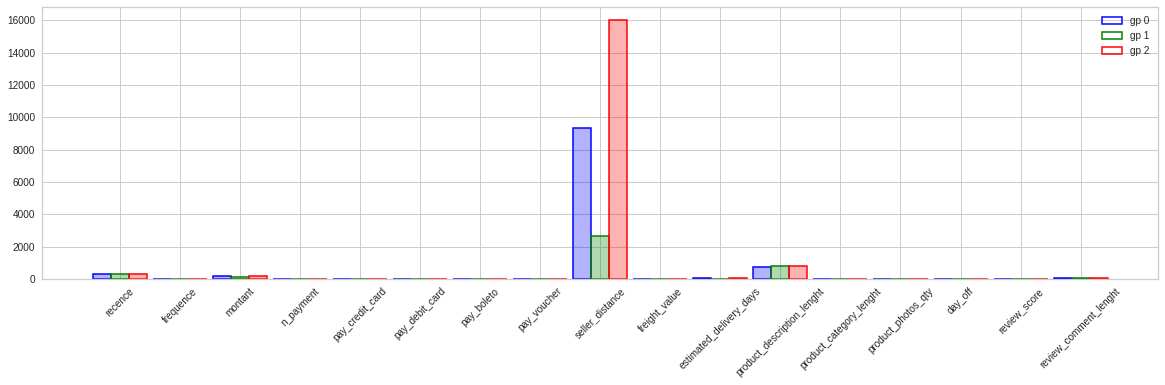

In [36]:
diagram(k_mean,X_names,color,figsize=(20,5),degrees=45)

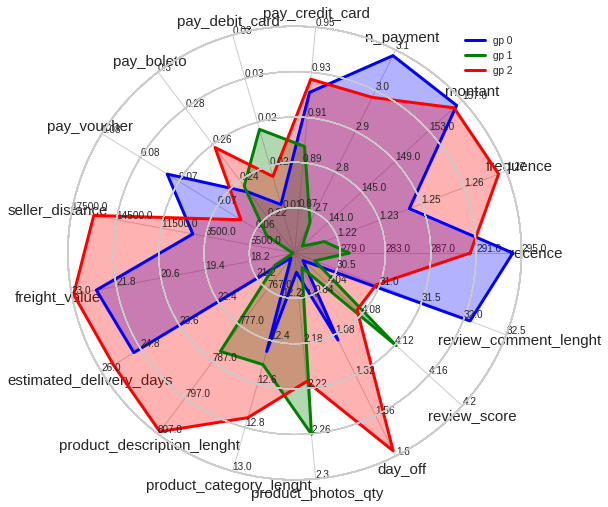

In [150]:
radar_chart(k_mean,k_ranges,color,figsize=(7,7),legend=True)

***Etiquettes :***
<ol>
    <li><strong>Groupe 0 (en bleu) : <em>petits clients</em></strong>
        <ul>
            <li>Comportement RFM : font peu d'achats, avec des montants moindres. mais ils ont pas passé des commande il n'y a pas trop longtemps.</li>
            <li>Préférence de paiement : en plusieurs fois et par carte de débit, de crédit et/ou par billets.</li>
            <li>Type de produits consultés : produits avec certaines informations (description, catégorie) et beaucoup de photos.</li>
            <li>Type de vendeurs fréquentés : vendeurs proches, sans ou avec de frais de livraison et de moindre temps de livraison.</li>
            <li>Retour : donnent des bonnes notes mais très peu de commentaires.</li>
        </ul>
    </li>
    <li><strong>Groupe 1 (en vert) : <em>moyens clients</em></strong>
        <ul>
            <li>Comportement RFM : font des achats moins fréquemment, mais dépensent beaucoup lors des achat. ils n'ont pas passé de commande depuis un grand moment.</li>
            <li>Préférence de paiement : en plusieurs fois et par carte de crédit et/ou par voucher.</li>
            <li>Type de produits consultés : produits avec peu d'information (description, catégorie, photo).</li>
            <li>Type de vendeurs fréquentés : vendeurs moins loins, mais avec des frais et temps de livraison assez chers.</li>
            <li>Retour : donnent des petites notes moyens mais beaucoup de commentaires.</li>
        </ul>
    </li>
    <li><strong>Groupe 2 (en rouge) : <em>gros clients</em></strong>
        <ul>
            <li>Comportement RFM : font des achats très fréquemment, dépensent pas mal lors des achats, mais n'ont pas passés de commande depuis un certain temps.</li>
            <li>Préférence de paiement : versements moins nombreux et paiement par carte de crédit et/ou par billets.</li>
            <li>Type de produits consultés : produits biens décrits et appartenants à des catégories bien renseignés, même avec peu de photos.</li>
            <li>Type de vendeurs fréquentés : vendeurs plus loins, donc avec des frais et temps de livraison plus conséquents.</li>
            <li>Retour : donnent des notes moyennes et peu de commentaires.</li>
        </ul>
    </li>
</ol>

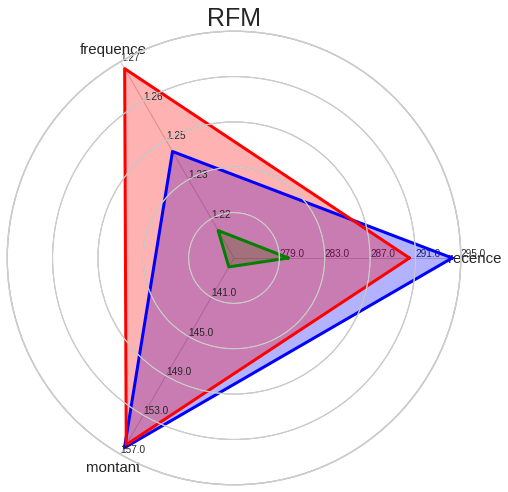

In [133]:
radar_chart(k_mean,k_ranges,color,0,3,title='RFM',figsize=(7,7))

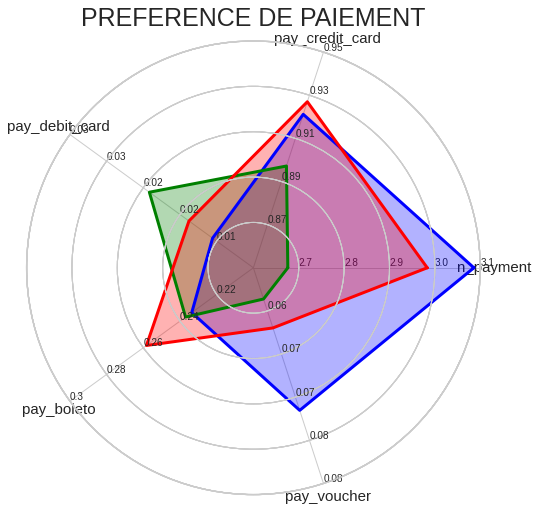

In [134]:
radar_chart(k_mean,k_ranges,color,3,8,title='PREFERENCE DE PAIEMENT',figsize=(7,7))

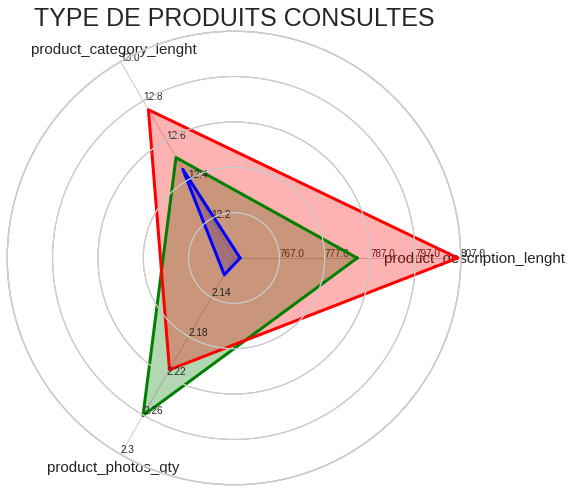

In [135]:
radar_chart(k_mean,k_ranges,color,11,14,title='TYPE DE PRODUITS CONSULTES',figsize=(7,7))

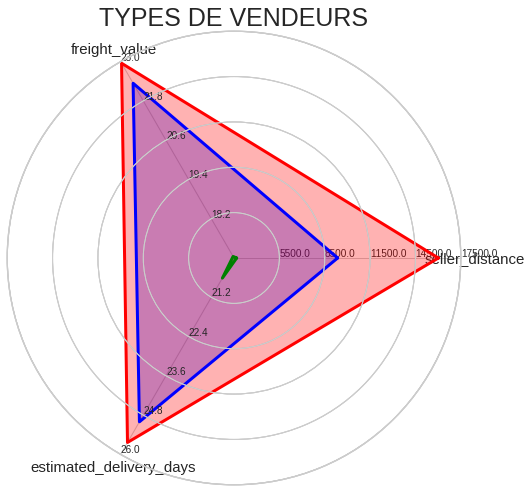

In [136]:
radar_chart(k_mean,k_ranges,color,8,11,title='TYPES DE VENDEURS',figsize=(7,7))

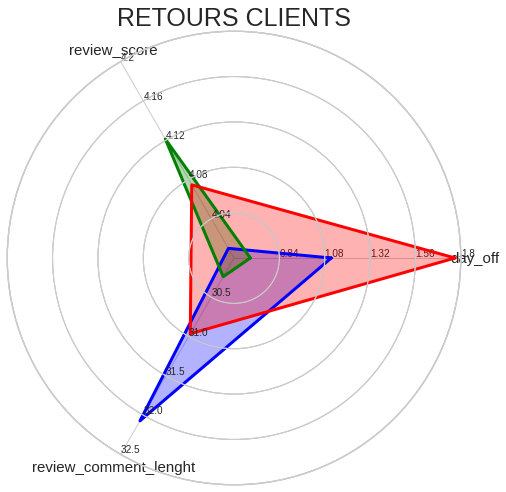

In [137]:
radar_chart(k_mean,k_ranges,color,14,title='RETOURS CLIENTS',figsize=(7,7))

<hr/>

## IV. Clustering RFM
<p>Dans cette section, on verra des essais de segmentations RFM.</p>

In [38]:
RFM_names = ['recence', 'frequence', 'montant']
RFM_values = X_features[RFM_names].values

In [39]:
RFM_etiquettes = ['recence','fréquence','montant']

### 1. k-means

### A) Essais de modèles

#### 1. DBSCAN

* **Estimation des paramètres**

In [40]:
RFM_minpts = 6 # ~2 fois la taille du jeu

In [41]:
RFM_neighbors = NearestNeighbors(n_neighbors=6) # ~2 fois la taille du jeu
RFM_neighbors_fit = RFM_neighbors.fit(RFM_values)
RFM_distances, RFM_indices = RFM_neighbors_fit.kneighbors(RFM_values)

RFM_distances = np.sort(RFM_distances, axis=0)
RFM_distances = RFM_distances[:,1]

(0.0, 10.0)

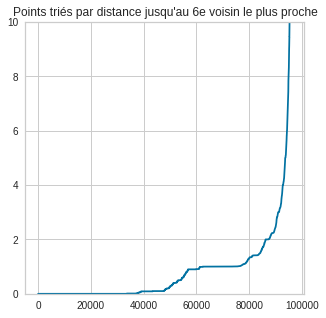

In [42]:
fig=plt.figure(figsize=(5,5))
plt.plot(RFM_distances)
plt.title("Points triés par distance jusqu'au 6e voisin le plus proche")
plt.ylim(0,10)

***Observation :*** Selon ce graphe, le paramètre eps serait ~1.75.

* **Implémentation des paramètres au modèle**

In [43]:
RFM_db = DBSCAN(eps=1.75,min_samples=minpts).fit(RFM_values)

* **Evaluation du modèle**

In [44]:
# nombre de clusters
RFM_db_labels = RFM_db.labels_
RFM_n_cluster = len(set(RFM_db_labels))

# silhouette coefficient
RFM_db_score_sil = metrics.silhouette_score(RFM_values,RFM_db_labels)

# davies bouldin score
RFM_db_score_db = metrics.davies_bouldin_score(RFM_values,RFM_db_labels)

In [45]:
print("Nombre de cluster: %i"% RFM_n_cluster)
print("Silhouette Coefficient: %0.3f"% RFM_db_score_sil)
print("Score Davies Bouldin: %0.3f"% RFM_db_score_db)

Nombre de cluster: 110
Silhouette Coefficient: -0.660
Score Davies Bouldin: 1.784


***Observation :*** D'après ces scores (silhouette proche de -1 et davies bouldin proche de 2) et surtout un nombre de cluster énorme (pas pertinent), DBSCAN n'est pas le meilleur modèle pour cette segmentation RFM.

#### 2. K-MEANS

* **Estimation du nombre de cluster**

<p>- Selon l'évolution des scores (Silhouette et Davies Bouldin)</p>

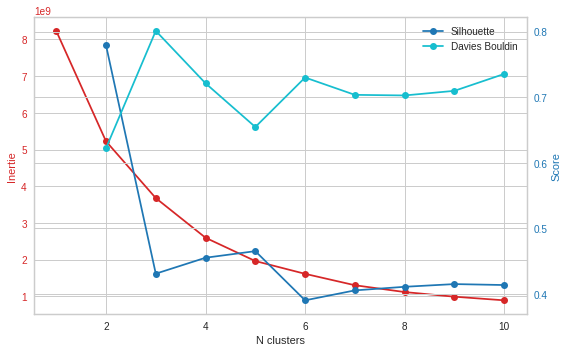

In [46]:
estimation_visualizer(RFM_values)

<p>- Selon la méthode Elbow</p>

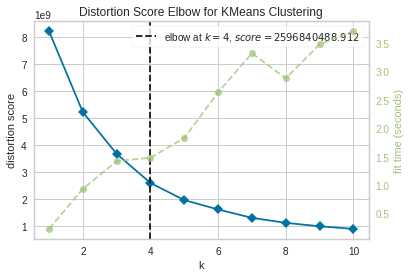

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
RFM_kmeans = KMeans()
visu_silhouette = KElbowVisualizer(RFM_kmeans, k=(1,11))
visu_silhouette.fit(RFM_values)
visu_silhouette.show()

***Observation :*** Selon la méthode Elbow, le nombre de cluster serait 4. Selon l'évolution des scores, ce nombre de cluster est également correct mais moins pertinent que pour n=5 (meilleur scores). On gardera donc pour la suite le nombre de cluster n=5.

* **Implémentation du clustering Kmeans avec nombre de clusters à 5**

In [48]:
# initialisation du modèle avec un nombre de cluster à 5
RFM_n_clusters=5
RFM_kmeans = KMeans(n_clusters=RFM_n_clusters).fit(RFM_values)

In [49]:
RFM_kmeans_labels = RFM_kmeans.labels_
RFM_kmeans_pred = RFM_kmeans.predict(RFM_values)

In [50]:
adjusted_rand_score(RFM_kmeans_labels,RFM_kmeans_pred)

1.0

In [51]:
# evaluation du modèle
RFM_kmeans_score_sil = metrics.silhouette_score(RFM_values,RFM_kmeans_labels)
print("Silhouette Coefficient: %0.3f"% RFM_kmeans_score_sil)

Silhouette Coefficient: 0.465


In [52]:
# evaluation du modèle Davies Bouldin
RFM_kmeans_score_db = metrics.davies_bouldin_score(RFM_values,RFM_kmeans_labels)
print("Score Davies Bouldin: %0.3f"% RFM_kmeans_score_db)

Score Davies Bouldin: 0.655


***Observation :*** D'après ces scores, K-MEANS est un assez bon modèle pour cette segmentation.
<p> On retiendra donc le modèle K-MEANS avec n_cluster = 5 pour la suite de l'étude.

### B) Etudes des clusters

#### 1. Visualisation des groupes

* **Score et taille**

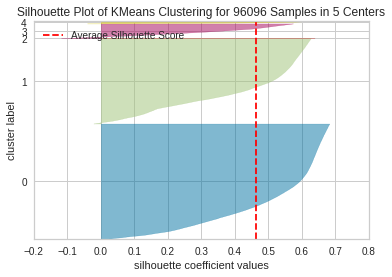

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96096 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [53]:
# Instantiate the clustering model and visualizer
visualizer = SilhouetteVisualizer(RFM_kmeans, colors='yellowbrick')
# Fit the data to the visualizer
visualizer.fit(RFM_values)        
# Finalize and render the figure
visualizer.show()        

***Observation :*** On remarque sur ce graphe que le nombre de cluster choisi est correct : 
<p>- tous les clusters ont un silhouette score supérieur au silhouette moyen qui est de 0.56, indiquant que chaque groupe est bien éloigné des autres.</p>
<p>- les épaisseurs du tracé des silhouette des clusters sont similaires, indiquant que la taille des cluster est assez similaires entre eux.</p>

* **Distance**

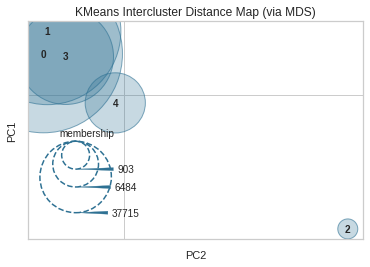

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [54]:
# Instantiate the clustering model and visualizer
visualizer = InterclusterDistance(RFM_kmeans)
# Fit the data to the visualizer
visualizer.fit(RFM_values)   
# Finalize and render the figure
visualizer.show()        

***Observation :*** ...

* **Représentation**

In [55]:
tsne = TSNE(n_components=2)
z = tsne.fit_transform(RFM_values)

<AxesSubplot:>

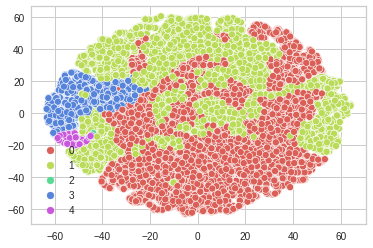

In [57]:
sns.scatterplot(x=z[:,0], y=z[:,1], hue=RFM_kmeans_labels, palette=sns.color_palette("hls", 5))

***Observation :*** ...

#### 2. Comportement des groupes

* **Données et Fonctions utiles**

In [58]:
X_features['RFM_gp'] = RFM_kmeans_labels

In [59]:
RFM_k_mean = X_features.groupby(['RFM_gp']).mean()[X_names]
RFM_k_std = X_features.groupby(['RFM_gp']).std()[X_names]

In [79]:
RFM_k_ranges = [(175,440), (1.1,7.2),(100,6900),(2.5,6),(0.8,1.4),
                (0.01,0.08), (0.2,0.5),(0.04,5.5),(8150,9150),
                (18.25,84.75), (22,26),(725,1650),(12,14),
                (2.1,2.6), (0,3.5),(3.5,4.1),(30,48)] 

In [61]:
RFM_color = ['red','green','cyan','violet','orange']
RFM_label = sorted(set(RFM_kmeans_labels))

* **Interpretation**

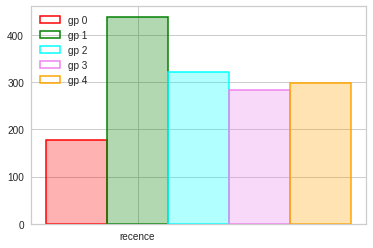

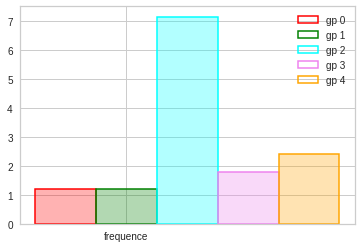

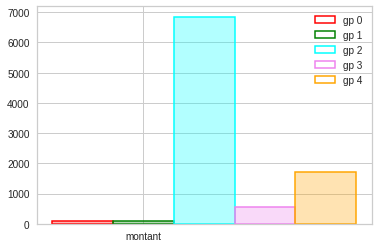

In [159]:
for i in range(len(RFM_names)):
    diagram(RFM_k_mean[[RFM_names[i]]],[RFM_names[i]],RFM_color)

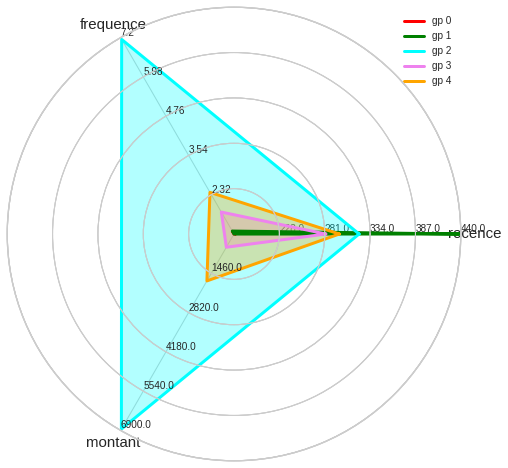

In [151]:
radar_chart(RFM_k_mean,RFM_k_ranges,RFM_color,0,3,figsize=(7,7),legend=True)

***Etiquettes :***
<ol>
    <li><strong>Groupe 0 (en rouge) : <em>petits clients ++</em></strong>
        <ul>
            <li>fréquence d'achats moindre,</li>
            <li>achats à petits prix,</li>
            <li>dernière commande assez récente.</li>
        </ul>
    </li>
    <li><strong>Groupe 1 (en vert) : <em>petits clients</em></strong>
        <ul>
            <li>fréquence d'achats moindre,</li>
            <li>achats à petits prix,</li>
            <li>dernière commande depuis longtemps.</li>
        </ul>
    </li>
    <li><strong>Groupe 2 (en cyan) : <em>gros clients</em></strong>
        <ul>
            <li>achats très fréquents,</li>
            <li>montants importants,</li>
            <li>dernière commande pas trop longtemps.</li>
        </ul>
    </li>
    <li><strong>Groupe 3 (en violet) : <em>clients moyens</em></strong>
        <ul>
            <li>fréquence d'achats moyennement basse,</li>
            <li>montants moyennement basse,</li>
            <li>dernière commande pas trop longtemps.</li>
        </ul>
    </li>
    <li><strong>Groupe 4 (en orange) : <em>clients moyens ++</em></strong>
        <ul>
            <li>fréquence d'achats moyennement haute,</li>
            <li>montants moyennement haute,</li>
            <li>dernière commande pas trop longtemps.</li>
        </ul>
    </li>
</ol>

<hr/>

## V. Choix du meilleur modèle

<p> En se basant sur les scores des segmentations, la meilleure est la segmentation K-Means tenant en compte toutes les variables (Silhouette à 0.56 et Davies à 0.53).</p>
<p> En se basant également sur les groupes retrouvés, la segmentation qui semble la plus correcte est la segmentation K-Means tenant en compte toutes les variables (3 groupes : petits, moyens et gros clients). En effet, en les groupes 0 et 1 de la segmentation RFM sont tous les deux des petits clients, la seule différence de ces groupes se base sur la date de la dernière commande. On imagine bien rassemblé ces 2 groupes en un seul : petits clients.</p>
<p> On choisira ainsi la <strong>segmentation K-Means tenant en compte toutes les variables</strong> pour cette étude.</p>

<hr/>

## VI. Maintenance du modèle

#### 1. Importations des données de commandes (non groupés selon les clients)

In [81]:
# importation du jeu de données à partir de .csv
data_all = pd.read_csv('../Dataset/data_all.csv',index_col=0)

In [82]:
col_str = ['order_id','customer_unique_id']
col_date = ['order_purchase_timestamp']

data_all[col_str] = data_all[col_str].astype('str')
data_all[col_date] = data_all[col_date].astype('datetime64[ns]')

In [83]:
data_all.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,estimated_delivery_days,seller_distance,product_category_lenght,review_comment_lenght,date_off,day_off
0,e22acc9c116caa3f2b7121bbb380d08e,fadbb3709178fc513abc1b2670aa1ad2,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,2018-05-21 00:00:00,1.0,372645c7439f9661fbbacfd129aa92ec,...,0,1,0,0,10,4504.736604,14,111,NaN,0.0
1,3594e05a005ac4d06a72673270ef9ec9,4cb282e167ae9234755102258dd52ee8,delivered,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,2018-05-15 00:00:00,1.0,5099f7000472b634fea8304448d20825,...,0,1,0,0,7,485.450140,13,3,NaN,0.0
2,b33ec3b699337181488304f362a6b734,9b3932a6253894a02c1df9d19004239f,delivered,2017-03-10 21:05:03,2017-03-10 21:05:03,2017-03-13 12:58:30,2017-04-05 14:38:47,2017-04-07 00:00:00,1.0,64b488de448a5324c4134ea39c28a34b,...,0,1,0,0,27,14954.133656,10,3,NaN,0.0


#### 2. Evaluation de la stabilité du modèle

In [90]:
def load_data(date_deb='2016-09-04',date_fin='2018-10-17'):
    date_deb = datetime.datetime.strptime(date_deb,'%Y-%m-%d')
    date_fin = datetime.datetime.strptime(date_fin,'%Y-%m-%d')
    filtered_data = data_all[(data_all['order_purchase_timestamp']>=date_deb)&
                             (data_all['order_purchase_timestamp']<=date_fin)]
    data_grouped = filtered_data.groupby('customer_unique_id')
    x_data = pd.DataFrame()
    # recence : date de la dernière commande
    x_data['recence']=data_grouped['order_purchase_timestamp'].max()
    date_max = x_data['recence'].max()
    x_data['recence']=date_max - x_data['recence']
    x_data['recence']=x_data['recence'].apply(lambda d:d.days)
    # frequence : nombre des commandes passées
    x_data['frequence']=data_grouped['order_id'].count()
    # montant : montant total de commandes
    x_data['montant']=data_grouped['price'].sum()
    # nombre de versements pour les paiements
    x_data['n_payment'] = data_grouped['payment_installments'].mean()
    # nombre de paiements par carte de crédit
    x_data['pay_credit_card'] = data_grouped['payment_type_credit_card'].sum()
    # nombre de paiements par carte de débit
    x_data['pay_debit_card'] = data_grouped['payment_type_debit_card'].sum()
    # nombre de paiements par billets
    x_data['pay_boleto'] = data_grouped['payment_type_boleto'].sum()
    # nombre de paiements par voucher
    x_data['pay_voucher'] = data_grouped['payment_type_voucher'].sum()
    # distance des vendeurs (maximum)
    x_data['seller_distance'] = data_grouped['seller_distance'].max()
    # frais de transport
    x_data['freight_value'] = data_grouped['freight_value'].max()
    # temps de livraison
    x_data['estimated_delivery_days'] = data_grouped['estimated_delivery_days'].max()
    # taille de description des produits
    x_data['product_description_lenght'] = data_grouped['product_description_lenght'].min()
    # tailles de description des catégories des produits
    x_data['product_category_lenght'] = data_grouped['product_category_lenght'].mean()
    # nombre de photos
    x_data['product_photos_qty'] = data_grouped['product_photos_qty'].min()
    # nombre de jours sans faire de commande
    x_data['day_off'] = data_grouped['day_off'].mean()
    # note moyenne de commande
    x_data['review_score'] = data_grouped['review_score'].mean()
    # tailles de message laissés en commentaire
    x_data['review_comment_lenght'] = data_grouped['review_comment_lenght'].mean()
    
    return x_data

In [91]:
load_data('2016-09-04','2017-09-04')

,recence,frequence,montant,n_payment,pay_credit_card,pay_debit_card,pay_boleto,pay_voucher,seller_distance,freight_value,estimated_delivery_days,product_description_lenght,product_category_lenght,product_photos_qty,day_off,review_score,review_comment_lenght
customer_unique_id,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,177,1,69.00,8.0,1,0,0,0,14954.133656,17.22,27,177.0,10.0,3.0,0.0,3.0,3.0
0005e1862207bf6ccc02e4228effd9a0,183,1,135.00,3.0,1,0,0,0,14703.665500,15.12,32,1118.0,24.0,6.0,0.0,4.0,3.0
0006fdc98a402fceb4eb0ee528f6a8d4,47,1,13.90,2.0,1,0,0,0,7368.508860,15.10,27,116.0,14.0,1.0,0.0,3.0,47.0
000a5ad9c4601d2bbdd9ed765d5213b3,23,1,76.99,3.0,1,0,0,0,1388.279352,14.29,25,711.0,13.0,3.0,0.0,4.0,3.0
000de6019bb59f34c099a907c151d855,17,2,229.80,4.0,2,0,0,0,4517.646618,17.33,19,167.0,14.0,1.0,0.0,2.0,136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff3a9369e4b7102fab406a334a678c3,23,1,84.90,2.0,1,0,0,0,10709.551948,17.84,23,573.0,19.0,1.0,0.0,5.0,3.0
fff699c184bcc967d62fa2c6171765f7,2,1,39.90,1.0,0,0,1,0,17849.302962,15.10,18,265.0,14.0,2.0,0.0,4.0,65.0
fffcf5a5ff07b0908bd4e2dbc735a684,87,2,1570.00,10.0,2,0,0,0,16650.936528,258.28,54,423.0,13.0,1.0,0.0,5.0,3.0


In [92]:
def score_ari(add_fin='2018-10-17',ref_deb='2016-09-04',ref_fin='2017-09-04'):
    # reference
    ref_x = load_data(ref_deb,ref_fin)
    ref_values = ref_x.values
    ref_kmeans = KMeans(n_clusters=3).fit(ref_values)
    ref_labels = ref_kmeans.labels_
    
    # add
    add_x = load_data(ref_deb,add_fin)
    add_values = add_x.values
    add_kmeans = KMeans(n_clusters=3).fit(add_values)
    add_x['gp'] = add_kmeans.labels_
    add_labels = add_x.gp[ref_x.index]
    
    return adjusted_rand_score(ref_labels,add_labels)

- stabilité du modèle pour toutes données avant '2017-09-04'

In [93]:
score_ari(add_fin='2018-01-01')

0.9831806141589009

- stabilité du modèle pour toutes données entre '2017-09-04' et '2018-09-04'

In [94]:
score_ari(add_fin='2018-09-04')

0.9715525710202612

***Observation :*** L'ARI n'est pas correct pour des données entre ces dates, cependant on ne sait pas encore à partir de quelle date le modèle n'est plus adéquat.

#### 3. Evolution de la stabilité du modèle en fonction du temps

In [95]:
def add_months(date='2016-09-04',month=1):
    d = datetime.datetime.strptime(date,'%Y-%m-%d')
    new_month = ((( d.month - 1) + month ) % 12 ) + 1
    new_year  = int(d.year + ((( d.month - 1) + month ) / 12 ))
    return str(new_year) + '-' + str(new_month) + '-' + str(d.day)

In [141]:
def evolution_ari(ref_deb='2016-09-04',ref_fin='2017-09-04',month=1,date_fin='2018-10-17'):
    list_date = []
    list_ari = []
    
    date = add_months(ref_deb,month)
    d = datetime.datetime.strptime(date,'%Y-%m-%d')
    d_ref_fin = datetime.datetime.strptime(ref_fin,'%Y-%m-%d')
    d_fin = datetime.datetime.strptime(date_fin,'%Y-%m-%d')
    
    while d <= d_fin:
        list_date.append(d)
        if d<=d_ref_fin:
            list_ari.append(1)
        else :
            list_ari.append(score_ari(add_fin=date,ref_deb=ref_deb,ref_fin=ref_fin))
        date = add_months(date,month)
        d = datetime.datetime.strptime(date,'%Y-%m-%d')

    return list_date,list_ari

In [142]:
list_date,list_ari = evolution_ari(ref_deb='2016-09-04',ref_fin='2017-04-04')

Text(0.5, 1.0, 'Stabilité du modèle')

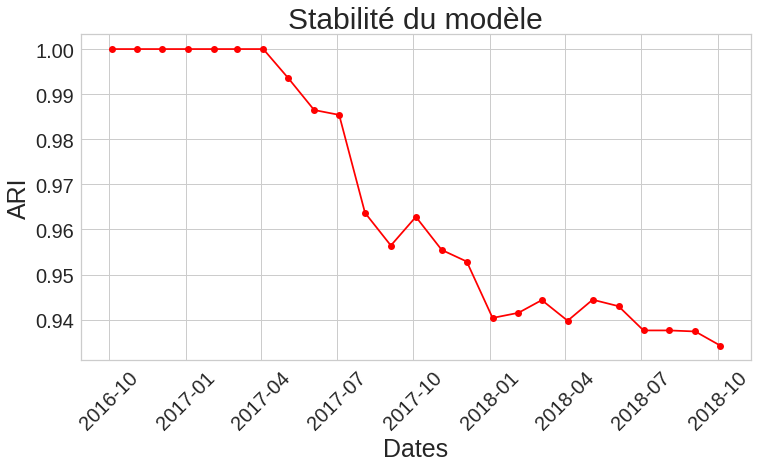

In [143]:
fig = plt.figure(figsize=(12,6))
plt.plot(list_date,list_ari,'o-',c='red')
plt.xticks(rotation=45,fontsize=20)
plt.xlabel('Dates',fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel('ARI',fontsize=25)
plt.title('Stabilité du modèle',fontsize=30)

***Observation :*** On voit à partir de ce graphe que le modèle est assez stable sur la durée de nos données.
<li>---> Choix de corrections à faire au cas où modèle ne sera plus pertinent à une date donnée :
    <ul>
        <li>vérifier minutieusement les données à  partir de cette date,</li>
        <li>établir un autre modèle à partir de cette date.</li>
    </ul>
</li>